# Spatial Transcriptomics Imputation with scGALA

## Introduction

Spatially resolved transcriptomics technologies like Xenium have revolutionized our understanding of tissue architecture and cellular organization by preserving spatial context during transcriptomic profiling. While these methods offer high-resolution spatial data, they typically capture only a few hundred genes compared to the thousands measured by conventional single-cell RNA sequencing approaches, limiting comprehensive spatial analysis of gene expression programs.

This technological constraint restricts the ability to investigate complex biological processes and regulatory networks within their native spatial contexts. Current spatial technologies like Xenium typically sequence only 300-500 genes, creating a significant gap in transcriptome-wide analysis capabilities.

In this tutorial, we demonstrate how to use scGALA to enhance spatial transcriptomics data by imputing missing genes using reference scRNA-seq datasets. Our approach combines graph-based cell alignment with an efficient implementation of ClusterGCN, enabling comprehensive transcriptome reconstruction while maintaining computational efficiency for large-scale spatial datasets.

Dataset can be accessed from [Figshare](https://figshare.com/articles/dataset/Label_Transfer_Example_Data/28728617).

## Setup and Data Loading

We begin by importing necessary libraries and setting random seeds for reproducibility. scGALA provides specialized components for alignment and imputation tasks.

In [ ]:
# Import required packages and set random seeds for reproducibility
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import torch
from scGALA import GNNImputer,MyDataModule_OneStage,get_alignments
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelSummary, LearningRateMonitor
import scipy.sparse as sp

np.random.seed(2233)
torch.manual_seed(2233)

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the number of genes to use for the spatial dataset
# This represents the typical number of genes available in spatial technologies like Xenium
N_gene = 300

Next, we load our reference scRNA-seq dataset and spatial transcriptomics dataset:

In [ ]:
# Load the reference scRNA-seq data and spatial transcriptomics data
RNA_adata = sc.read('./Reference_RNA.h5ad')
ST_adata = sc.read('./ST_cf7.h5ad')

RNA_adata, ST_adata

(AnnData object with n_obs × n_vars = 21178 × 32170
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'nCount_ATAC', 'nFeature_ATAC', 'bio_origin', 'atac_raw_reads', 'gex_raw_reads', 'pANN', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT_CC', 'nFeature_SCT_CC', 'atac_peak_region_fragments', 'atac_fragments', 'atac_peak_fraction', 'SCT_CC.weight', 'ATAC.weight', 'wsnn_cc_res.0.2', 'seurat_clusters', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l4.score', 'predicted.celltype.l4', 'cell_flight_status', 'annotations'
     var: 'name'
     obsm: 'X_atac_harmony', 'X_atac_lsi', 'X_cca', 'X_ref.umap', 'X_sct_cc_harmony', 'X_sct_cc_pca', 'X_sct_harmony', 'X_sct_pca', 'X_wnn_cc_umap',
 AnnData object with n_obs × n_vars = 6291 × 14630
     obs: 'nCount_RNA', 'nFeature_RNA', 'section.name', 'id', 'nCount_SCT',

## Data Preprocessing

Before alignment and imputation, we need to preprocess both datasets by normalizing, log-transforming, and selecting highly variable genes:

In [ ]:
# Perform standard preprocessing steps:
# 1. Total count normalization (scaling to 10,000 counts per cell)
# 2. Log transformation
# 3. Highly variable gene selection
# 4. Concatenation of datasets for joint analysis
sc.pp.normalize_total(RNA_adata, target_sum=1e4)
sc.pp.log1p(RNA_adata)
sc.pp.normalize_total(ST_adata, target_sum=1e4)
sc.pp.log1p(ST_adata)
sc.pp.highly_variable_genes(ST_adata, n_top_genes=N_gene)
ST_adata = ST_adata[:,ST_adata.var['highly_variable']]
combined = sc.concat([RNA_adata, ST_adata], join='inner',merge=None,label='dataset',keys=['RNA','ST'])
combined

AnnData object with n_obs × n_vars = 27469 × 296
    obs: 'nCount_RNA', 'nFeature_RNA', 'bio_origin', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'dataset'

In [ ]:
# Check the relative sizes of our datasets
combined.obs['dataset'].value_counts()

dataset
RNA    21178
ST      6291
Name: count, dtype: int64

In [6]:
# Scale data, convert cluster labels to string type, and save the preprocessed datasets
sc.pp.scale(combined)
combined.obs['seurat_clusters'] = combined.obs['seurat_clusters'].astype(str)
combined.write(f'./Result/intermidate/combined_hvg_scaled_{N_gene}.h5ad')

## Get alignments

The first key step in our imputation approach is to establish meaningful alignments between cells in our reference scRNA-seq data and spatial data. scGALA uses a graph neural network approach to find optimal cell pairings.

In [7]:
# Load the preprocessed data for alignment
combined = sc.read(f'./Result/intermidate/combined_hvg_scaled_{N_gene}.h5ad')

In [8]:
# Split the combined data back into reference RNA-seq and spatial datasets
adata1 = combined[combined.obs['dataset']=='RNA']
adata2 = combined[combined.obs['dataset']=='ST']

### Running the Alignment Model

The `get_alignments` function identifies corresponding cells between modalities using a graph-based approach. This step is critical as it determines which reference cells will contribute information to our spatial data.

In [ ]:
# Run the alignment process between reference (adata1) and spatial (adata2) datasets
# Parameters explained:
# - min_value: Alignment confidence threshold
# - lamb: Balance parameter for alignment optimization
# - devices: GPU device to use
# - lr: Learning rate
# - min_epochs: Minimum training iterations
alignments_matrix = get_alignments(adata1=adata1,adata2=adata2,min_value=0.9,lamb=0.8,devices=[0],lr=1e-3,replace=True,min_epochs=20) #,ckpt_dir='./lightning_logs/version_4/checkpoints/epoch=12-step=260.ckpt'
mutual_1 , mutual_2 = alignments_matrix.nonzero()
rna_st_align = pd.DataFrame({'RNA':adata1.obs.index[mutual_1].tolist(),'ST':adata2.obs.index[mutual_2].tolist()})
rna_st_align.to_csv(f'./Result/intermidate/rna_st_align_{N_gene}.csv',index=False)

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


normalizing
normalization done
tree done
query done
func:'find_mutual_nn' took: 3.5765 sec


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type   | Params
---------------------------------
0 | model | MSVGAE | 158 K 
---------------------------------
158 K     Trainable params
0         Non-trainable params
158 K     Total params
0.635     Total estimated model params size (MB)


start to train
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s, v_num=14, train_loss=10.50, decoder_loss=9.120, auc=0.823, ap=0.799, ave_align=88.90]         

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


Epoch 19: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s, v_num=14, train_loss=8.300, decoder_loss=7.300, auc=0.939, ap=0.927, ave_align=68.80]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.



Model Training Time: 297.20576548576355 Seconds
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s]
0.9 0.8


100%|█████████▉| 99.70235110353387/100 [06:35<00:01,  3.96s/it, epoch=99, marriage_sum=1.52e+3, max_aligned_R=1, aligned_R=1567, mean_aligned_R=0.999, max_aligned_D=1, aligned_D=1567, mean_aligned_D=0.999]


R:21178 D:6291


# Gene Imputation with Graph Neural Networks

After establishing cell alignments, we can now enhance our spatial transcriptomics data by imputing missing genes using our reference scRNA-seq dataset.

First, we reload and prepare our original datasets for imputation:

In [ ]:
# Load the original datasets and preprocess them for imputation
RNA_adata = sc.read_h5ad('./Reference_RNA.h5ad')
ST_adata = sc.read_h5ad('./ST_cf7.h5ad')

sc.pp.normalize_total(RNA_adata, target_sum=1e4)
sc.pp.log1p(RNA_adata)
sc.pp.highly_variable_genes(RNA_adata, n_top_genes=2000)
sc.pp.normalize_total(ST_adata, target_sum=1e4)
sc.pp.log1p(ST_adata)
sc.pp.highly_variable_genes(ST_adata, n_top_genes=N_gene)

In [ ]:
# Leverage the alignments to select a balanced subset of reference cells
# We combine aligned RNA cells with randomly selected non-aligned cells
rna_st_align = pd.read_csv(f'./Result/intermidate/rna_st_align_{N_gene}.csv')
mnn1,mnn2 = rna_st_align['RNA'].tolist(),rna_st_align['ST'].tolist()
RNA_adata.obs['aligned'] = RNA_adata.obs_names.isin(mnn1)
chosen_cells = np.random.choice(RNA_adata.obs_names[~RNA_adata.obs['aligned']],size=ST_adata.shape[0]*2,replace=False).tolist()
chosen_cells = chosen_cells + mnn1
# chosen_cells = list(set(chosen_cells)) # remove duplicates

RNA_adata = RNA_adata[chosen_cells].copy()

if sp.issparse(ST_adata.X):
    ST_adata.X = ST_adata.X.toarray()
if sp.issparse(RNA_adata.X):
    RNA_adata.X = RNA_adata.X.toarray()
print(RNA_adata.shape,ST_adata.shape)

(14149, 32170) (6291, 14630)


In [13]:
# Select highly variable genes from both datasets
# Ensure that genes present in the spatial data are included in our reference dataset
hvg_genenames = ST_adata.var_names[ST_adata.var['highly_variable']].tolist()
ST_adata_gene500 = ST_adata[:,hvg_genenames]
hvg_gene_rna = RNA_adata.var_names[RNA_adata.var['highly_variable']].tolist()
hvg_gene_rna = list(set(hvg_gene_rna) | set(hvg_genenames) & set(RNA_adata.var_names))
RNA_adata = RNA_adata[:,hvg_gene_rna].copy()

## Dimensionality Reduction

We perform PCA on both datasets to prepare them for the imputation model:

In [14]:
# Perform dimensionality reduction on both datasets
sc.pp.pca(ST_adata_gene500)
sc.pp.pca(RNA_adata)

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


## Building the Data Module

We create a specialized data module that organizes both datasets and their connections for the imputation model:

In [15]:
# Create the data module for imputation
# This module:
# - Identifies matching genes between datasets
# - Constructs a graph connecting similar cells
# - Prepares batched data for model training
mydatamodule = MyDataModule_OneStage(adata=RNA_adata,target_adata=ST_adata_gene500,k=20,save=True,mnn1=mnn1,mnn2=mnn2)
n_matching_genes = mydatamodule.n_matching_genes
n_all_genes = RNA_adata.shape[1]

Time taken to reorder adata genes: 0.0104 seconds
296 matching genes and 1892 only in adata
var_names saved in var_names_one_stage.txt


## Training the Imputation Model

Now we train a Graph Neural Network model (GNNImputer) to transfer gene information between datasets:

In [16]:
# Configure and train the imputation model
# Model configuration:
# - ClusterGCN layer type for efficient graph processing
# - 128 hidden channels for feature representation
# - 2 graph convolutional layers
# - Early stopping to prevent overfitting
early_stopping = EarlyStopping('train_loss',patience=30,mode='min',min_delta=1e-4)
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = Trainer(max_epochs=-1,devices=[1],log_every_n_steps=1,callbacks=[early_stopping,ModelSummary(max_depth=2),lr_monitor],default_root_dir='./GNNImputer')
model = GNNImputer(num_features=n_all_genes,n_matching_genes=n_matching_genes,hidden_channels=128,num_layers=2,heads=1,dropout=0.,learning_rate=1e-3,layer_type='ClusterGCN')
trainer.fit(model=model,datamodule=mydatamodule)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
Missing logger folder: GNNImputer/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name           | Type           | Params
--------------------------------------------------
0 | convs          | Sequential     | 1.1 M 
1 | convs.module_0 | Dropout        | 0     
2 | convs.module_1 | ClusterGCNConv | 560 K 
3 | convs.module_2 | ReLU           | 0     
4 | convs.module_3 | Dropout        | 0     
5 | convs.module_4 | ClusterGCNConv | 562

Epoch 1528: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, v_num=0, train_loss=0.0858, loss_RNA=0.0482, loss_ST=0.0376]


## Generating Imputed Datasets

After training, we use the model to predict the full gene expression profiles:

In [17]:
# Generate imputed expression profiles using the trained model
prediction = trainer.predict(model=model,datamodule=mydatamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


In [18]:
# Process the predictions and save the resulting imputed datasets
# For spatial data, we preserve the original expression values for measured genes
combined_pred,bias = prediction[0]
# combined_pred = combined_pred.cpu().numpy()
var_names = np.loadtxt('./var_names_one_stage.txt',dtype=str)[1:].tolist()
combined_pred[bias:,:n_matching_genes] = ST_adata_gene500[:,var_names[:n_matching_genes]].X
predicted_RNA_adata = ad.AnnData(X=combined_pred[:bias],obs=RNA_adata.obs)
predicted_RNA_adata.var_names = var_names
predicted_RNA_adata.write(f'./predicted_RNA_adata_one_stage_no_dropout_{N_gene}.h5ad')
predicted_ST_adata = ad.AnnData(X=combined_pred[bias:],obs=ST_adata_gene500.obs)
predicted_ST_adata.var_names = var_names
predicted_ST_adata.write(f'./predicted_ST_adata_one_stage_no_dropout_{N_gene}.h5ad')

## Analysis and Visualization of Results

Let's examine the imputed data and visualize the results:

In [ ]:
# Examine the imputed reference data
predicted_RNA_adata.to_df().head()

,Osgin1,Gltp,Rgs9,Slc6a13,Ptpn3,Gjc3,Gab1,Lgi2,Pcp4,S100a6,...,Slc13a3,Gm15853,Etl4,Il7r,Pdgfra,Olfr220,Arhgap28,Gm12798,Cbln3,Ndufb7
CAACCCTTCTCCTCAA-3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
TGTAAAGCAGTGAACG-5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.160266,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
CTTAGTTTCGCACACA-3,0.0,0.0,0.0,0.0,2.199025,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.865391,0.000000
CTCACAACAGCTCAAC-5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,2.017168,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
GCACGAACACAAAGAC-4,0.0,0.0,0.0,0.0,0.000000,0.0,0.840604,0.0,0.0,0.0,...,0.0,0.0,1.008314,0.0,0.0,0.0,0.0,0.0,0.000000,0.271933


In [ ]:
# Compare with the original reference data
RNA_adata[:,var_names].to_df().head()

,Osgin1,Gltp,Rgs9,Slc6a13,Ptpn3,Gjc3,Gab1,Lgi2,Pcp4,S100a6,...,Slc13a3,Gm15853,Etl4,Il7r,Pdgfra,Olfr220,Arhgap28,Gm12798,Cbln3,Ndufb7
CAACCCTTCTCCTCAA-3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
TGTAAAGCAGTGAACG-5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
CTTAGTTTCGCACACA-3,0.0,0.0,0.0,0.0,1.971365,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.971365,0.0
CTCACAACAGCTCAAC-5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,3.039299,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
GCACGAACACAAAGAC-4,0.0,0.0,0.0,0.0,0.000000,0.0,2.521049,0.0,0.0,0.0,...,0.0,0.0,2.521049,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Finally, we perform dimensionality reduction and visualization to examine the quality of our imputed data:

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


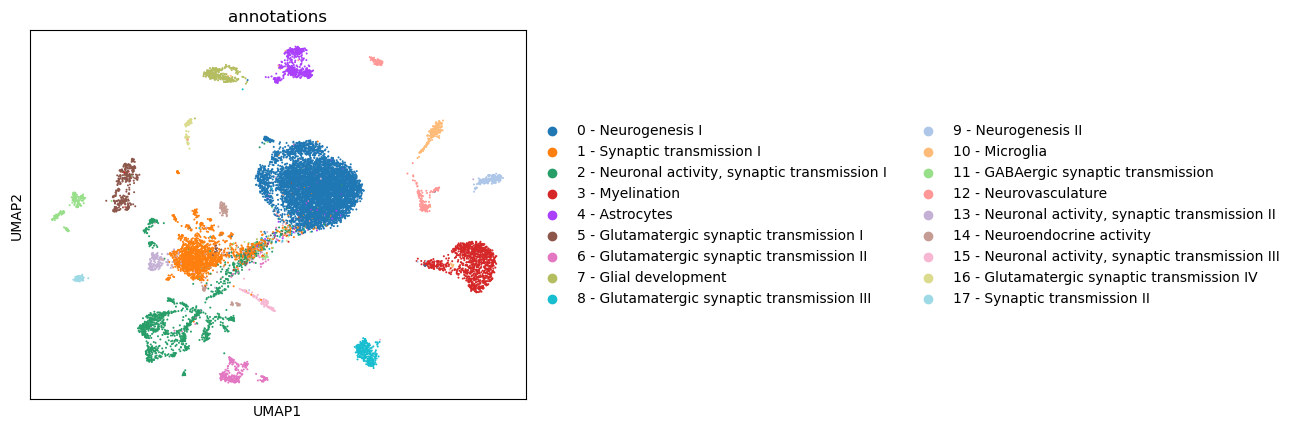

In [ ]:
# Visualize the imputed reference RNA data
sc.pp.pca(predicted_RNA_adata)
sc.pp.neighbors(predicted_RNA_adata)
sc.tl.umap(predicted_RNA_adata)
sc.pl.umap(predicted_RNA_adata,color=['annotations'])

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


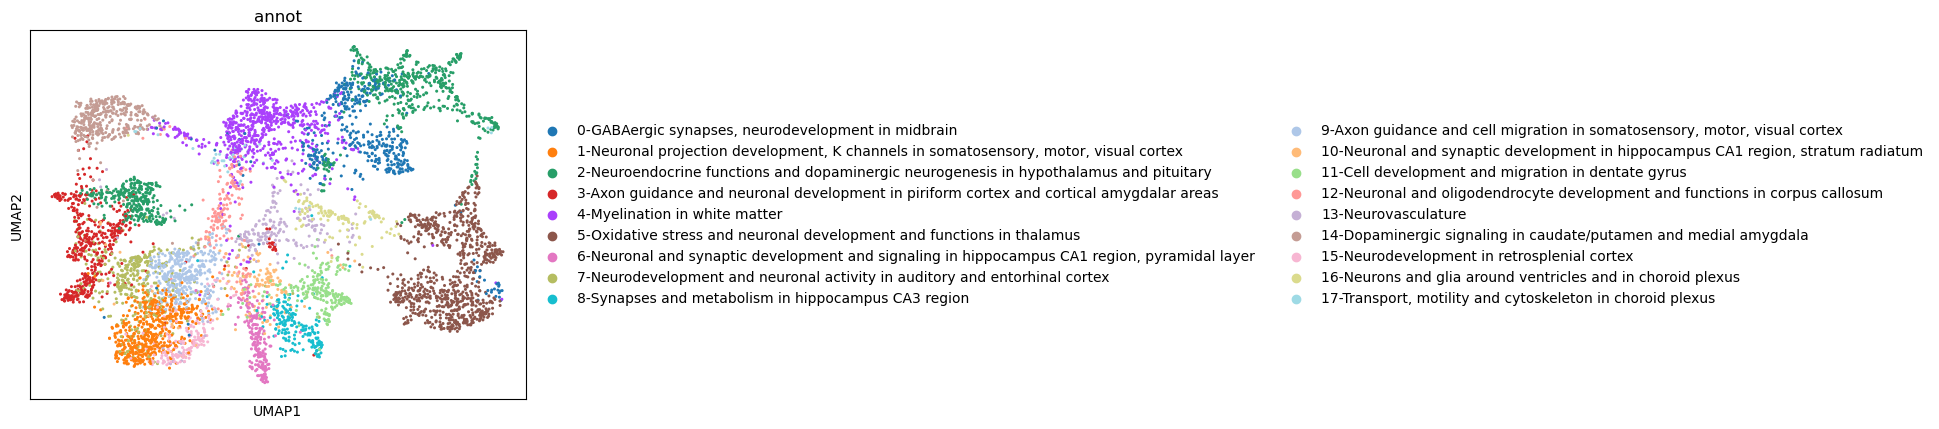

In [ ]:
# Visualize the imputed spatial data
sc.pp.pca(predicted_ST_adata)
sc.pp.neighbors(predicted_ST_adata)
sc.tl.umap(predicted_ST_adata)
sc.pl.umap(predicted_ST_adata,color=['annot'])

## Conclusion

In this tutorial, we demonstrated how scGALA can effectively enhance spatial transcriptomics data by imputing genes from reference scRNA-seq datasets. The approach preserves the biological structure of the data while significantly increasing gene coverage, enabling more comprehensive analysis of spatial transcriptomics data.

Key advantages of this approach include:
1. Preservation of spatial information
2. Enhanced gene coverage for pathway analysis
3. Integration of complementary data modalities
4. Maintained biological fidelity through graph-based learning

This imputation strategy addresses a critical limitation of current spatial technologies and enables researchers to conduct more comprehensive analyses of spatial gene expression patterns.